# Prediction of COVID19 future cases

In [0]:
import requests
import json
import pandas as pd
import numpy as np

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
response = requests.get("https://api.covid19india.org/data.json")
# Get the response data as a python object. Verify that it's a dictionary.
data = response.json()
a=[pd.Series(x) for x in data['cases_time_series']]

In [0]:
#data_dict = json.loads(data)
df=pd.DataFrame(a)
df.head()

,dailyconfirmed,dailydeceased,dailyrecovered,date,totalconfirmed,totaldeceased,totalrecovered
0,1,0,0,30 January,1,0,0
1,0,0,0,31 January,1,0,0
2,0,0,0,01 February,1,0,0
3,1,0,0,02 February,2,0,0
4,1,0,0,03 February,3,0,0


In [0]:
df.iloc[:,3:].head()

,date,totalconfirmed,totaldeceased,totalrecovered
0,30 January,1,0,0
1,31 January,1,0,0
2,01 February,1,0,0
3,02 February,2,0,0
4,03 February,3,0,0


In [0]:
df1=df.iloc[:,4:] #selecting last 3 features of dataframe

#Using the day counts from January 30 (i.e. index) as a feature because we cannot directly pass dates into model
df1['date_diff']=df1.index

#Converting numeric features into type integer
df1.totalconfirmed=df1.totalconfirmed.astype('int')
df1.totaldeceased=df1.totaldeceased.astype('int')
df1.totalrecovered=df1.totalrecovered.astype('int')
#df1.sample()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


## Visualizing the data

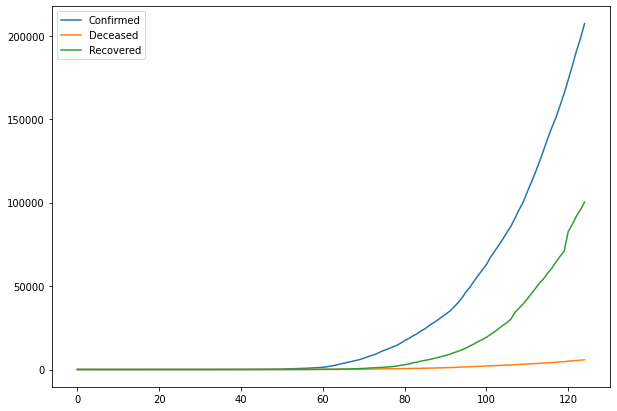

In [0]:
plt.figure(figsize=(10,7))
df1['totalconfirmed'].plot(label='Confirmed')
df1['totaldeceased'].plot(label='Deceased')
df1['totalrecovered'].plot(label='Recovered')
plt.legend()
plt.show()

As the values show non linearity, so we need to fit a polynomial curve instead of a straight line to get better results.

### Importing modules and methods for model building and evaluation

In [0]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error

## Confirmed cases

In [0]:
confirmed_score={} #storing RMSE scores

### Spliiting data into train and test set

In [0]:
x=df1[['date_diff']]
y=df1['totalconfirmed']
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test= train_test_split(x, y, test_size=0.2)


### SVR with polynomial kernel

In [0]:
# Grid searchCV for hyperparameter tuning
param_grid = [{'degree': [5, 6, 7]}]
grid_search = GridSearchCV(SVR(kernel='poly'), param_grid, cv=5,scoring='neg_mean_squared_error',return_train_score=True)
_=grid_search.fit(x_train, y_train)
grid_search.best_params_

{'degree': 6}

In [0]:
svr1=SVR(kernel='poly', degree=6)
svr1.fit(x_train, y_train)
y_pred1=svr1.predict(x_test)

In [0]:
confirmed_score['svr']= np.sqrt(mean_squared_error(y_test,y_pred1))
print("r2_score training: ",svr1.score(x_train,y_train)) # r2_score training
print("r2_score testing: ",r2_score(y_test,y_pred1)) # r2_score testing
print("Root mean square error of testing data: ",np.sqrt(mean_squared_error(y_test,y_pred1))) # rmse testing

r2_score training:  0.9987799954063143
r2_score testing:  0.9976519449452714
Root mean square error of testing data:  2971.2163288398656


### Using a pipeline to apply Polynomial features and regression

In [0]:
pipeline1 = Pipeline(steps=[('poly', PolynomialFeatures(degree=6)), ('linear', LinearRegression())])
pipeline1.fit(np.array(x_train).reshape(-1,1),y_train)
y_pred1=pipeline1.predict(np.array(x_test).reshape(-1,1))

In [0]:
confirmed_score['lr']=np.sqrt(mean_squared_error(y_test,y_pred1))
print("r2_score training: ",pipeline1.score(x_train,y_train)) # r2_score training
print("r2_score testing: ",r2_score(y_test,y_pred1)) # r2_score testing
print("Root mean square error of testing data: ",np.sqrt(mean_squared_error(y_test,y_pred1))) # rmse testing

r2_score training:  0.9999128315184596
r2_score testing:  0.9999145381860488
Root mean square error of testing data:  566.847438751138


### Decision tree regressor

In [0]:
# Grid searchCV for hyperparameter tuning
param_grid = [{'max_depth': [1, 2, 3, 4, None]}]
grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5,scoring='neg_mean_squared_error',return_train_score=True)
grid_search.fit(x_train, y_train)
grid_search.best_params_

{'max_depth': None}

In [0]:
dt1=DecisionTreeRegressor()
dt1.fit(x_train, y_train)
y_pred1=dt1.predict(x_test)

In [0]:
confirmed_score['dt']= np.sqrt(mean_squared_error(y_test,y_pred1))
print("r2_score training: ",dt1.score(x_train,y_train)) # r2_score training
print("r2_score testing: ",r2_score(y_test,y_pred1)) # r2_score testing
print("Root mean square error of testing data: ",np.sqrt(mean_squared_error(y_test,y_pred1))) # rmse testing

r2_score training:  1.0
r2_score testing:  0.9971313772542256
Root mean square error of testing data:  3284.1036402647223


In [0]:
confirmed_score

{'dt': 3284.1036402647223, 'lr': 566.847438751138, 'svr': 2971.2163288398656}

So, we have obtained better r2 scores for training and testing data with **Linear regression + Polynomial features**. This shows no sign of underfitting or overfitting. And compared to the dataset values, the RMSE score is also quite low.

## Deceased cases

In [0]:
deceased_score={}

### Spliiting data into train and test set

In [0]:
x=df1[['date_diff']]
y=df1['totalrecovered']
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test= train_test_split(x, y, test_size=0.2)


### SVR with polynomial kernel

In [0]:
# Grid searchCV for hyperparameter tuning
param_grid = [{'degree': [6, 7, 8]}]
grid_search = GridSearchCV(SVR(kernel='poly'), param_grid, cv=3,scoring='neg_mean_squared_error',return_train_score=True)
_=grid_search.fit(x_train, y_train)
grid_search.best_params_

{'degree': 8}

In [0]:
svr2=SVR(kernel='poly', degree=8)
svr2.fit(x_train, y_train)
y_pred2=svr2.predict(x_test)

In [0]:
deceased_score['svr']= np.sqrt(mean_squared_error(y_test,y_pred2))
print("r2_score training: ",svr2.score(x_train,y_train)) # r2_score training
print("r2_score testing: ",r2_score(y_test,y_pred2)) # r2_score testing
print("Root mean square error of testing data: ",np.sqrt(mean_squared_error(y_test,y_pred2))) # rmse testing

r2_score training:  0.9981920235971123
r2_score testing:  0.9992158597712857
Root mean square error of testing data:  598.8063279262572


### Using a pipeline to apply Polynomial features and regression

In [0]:
pipeline2 = Pipeline(steps=[('poly', PolynomialFeatures(degree=4)), ('linear', LinearRegression())])
pipeline2.fit(np.array(x_train).reshape(-1,1),y_train)
y_pred2=pipeline2.predict(np.array(x_test).reshape(-1,1))

In [0]:
deceased_score['lr']=np.sqrt(mean_squared_error(y_test,y_pred2))
print("r2_score training: ",pipeline2.score(x_train,y_train)) # r2_score training
print("r2_score testing: ",r2_score(y_test,y_pred2)) # r2_score testing
print("Root mean square error of testing data: ",np.sqrt(mean_squared_error(y_test,y_pred2))) # rmse testing

r2_score training:  0.9980389977688666
r2_score testing:  0.9978008534848637
Root mean square error of testing data:  1002.8052429864887


### Decision tree regressor

In [0]:
# Grid searchCV for hyperparameter tuning
param_grid = [{'max_depth': [1, 2, 3, 4, None]}]
grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5,scoring='neg_mean_squared_error',return_train_score=True)
grid_search.fit(x_train, y_train)
grid_search.best_params_

{'max_depth': None}

In [0]:
dt2=DecisionTreeRegressor()
dt2.fit(x_train, y_train)
y_pred2=dt2.predict(x_test)

In [0]:
deceased_score['dt']= np.sqrt(mean_squared_error(y_test,y_pred2))
print("r2_score training: ",dt2.score(x_train,y_train)) # r2_score training
print("r2_score testing: ",r2_score(y_test,y_pred2)) # r2_score testing
print("Root mean square error of testing data: ",np.sqrt(mean_squared_error(y_test,y_pred2))) # rmse testing

r2_score training:  1.0
r2_score testing:  0.9957169675904252
Root mean square error of testing data:  1399.475158764885


In [0]:
deceased_score

{'dt': 1399.475158764885, 'lr': 1002.8052429864887, 'svr': 598.8063279262572}

So, we have obtained quite good r2 scores for training and testing data with **SVR (polynomial kernel)**. This shows no sign of underfitting or overfitting. And compared to the dataset values, the RMSE score is also quite low.

## Recovered cases

In [0]:
recovered_score={}

### Spliiting data into train and test set

In [0]:
x=df1[['date_diff']]
y=df1['totalrecovered']
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test= train_test_split(x, y, test_size=0.2)


### SVR with polynomial kernel

In [0]:
# Grid searchCV for hyperparameter tuning
param_grid = [{'degree': [7, 8, 9]}]
grid_search = GridSearchCV(SVR(kernel='poly'), param_grid, cv=3,scoring='neg_mean_squared_error',return_train_score=True)
_=grid_search.fit(x_train, y_train)
grid_search.best_params_

{'degree': 8}

In [0]:
svr3=SVR(kernel='poly', degree=8)
svr3.fit(x_train, y_train)
y_pred3=svr3.predict(x_test)

In [0]:
recovered_score['svr']= np.sqrt(mean_squared_error(y_test,y_pred3))
print("r2_score training: ",svr3.score(x_train,y_train)) # r2_score training
print("r2_score testing: ",r2_score(y_test,y_pred3)) # r2_score testing
print("Root mean square error of testing data: ",np.sqrt(mean_squared_error(y_test,y_pred3))) # rmse testing

r2_score training:  0.9982131936261183
r2_score testing:  0.9985077123310289
Root mean square error of testing data:  596.7208550516979


### Using a pipeline to apply Polynomial features and regression

In [0]:
pipeline3 = Pipeline(steps=[('poly', PolynomialFeatures(degree=5)), ('linear', LinearRegression())])
pipeline3.fit(np.array(x_train).reshape(-1,1),y_train)
y_pred3=pipeline3.predict(np.array(x_test).reshape(-1,1))

In [0]:
recovered_score['lr']=np.sqrt(mean_squared_error(y_test,y_pred3))
print("r2_score training: ",pipeline3.score(x_train,y_train)) # r2_score training
print("r2_score testing: ",r2_score(y_test,y_pred3)) # r2_score testing
print("Root mean square error of testing data: ",np.sqrt(mean_squared_error(y_test,y_pred3))) # rmse testing

r2_score training:  0.9991504408779787
r2_score testing:  0.9990360916468183
Root mean square error of testing data:  479.5819323219088


### Decision tree regressor

In [0]:
# Grid searchCV for hyperparameter tuning
param_grid = [{'max_depth': [1, 2, 3, 4, None]}]
grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5,scoring='neg_mean_squared_error',return_train_score=True)
grid_search.fit(x_train, y_train)
grid_search.best_params_

{'max_depth': None}

In [0]:
dt3=DecisionTreeRegressor()
dt3.fit(x_train, y_train)
y_pred3=dt3.predict(x_test)

In [0]:
recovered_score['dt']= np.sqrt(mean_squared_error(y_test,y_pred3))
print("r2_score training: ",dt3.score(x_train,y_train)) # r2_score training
print("r2_score testing: ",r2_score(y_test,y_pred3)) # r2_score testing
print("Root mean square error of testing data: ",np.sqrt(mean_squared_error(y_test,y_pred3))) # rmse testing

r2_score training:  1.0
r2_score testing:  0.9950802299847809
Root mean square error of testing data:  1083.4711255958784


So, we have obtained quite good r2 scores for training and testing data with **Linear regression + Polynomial features**. This shows no sign of underfitting or overfitting. And compared to the dataset values, the RMSE score is also quite low.

In [0]:
recovered_score

{'dt': 1083.4711255958784, 'lr': 479.5819323219088, 'svr': 596.7208550516979}

### Comparing models

In [0]:
df_score=pd.DataFrame([pd.Series(confirmed_score),pd.Series(deceased_score),pd.Series(recovered_score)], index=['confirmed','deceased','recovered'])
df_score

,svr,lr,dt
confirmed,2971.216329,566.847439,3284.103640
deceased,598.806328,1002.805243,1399.475159
recovered,596.720855,479.581932,1083.471126


Let's plot the graph of predicted cases for next 80 days.

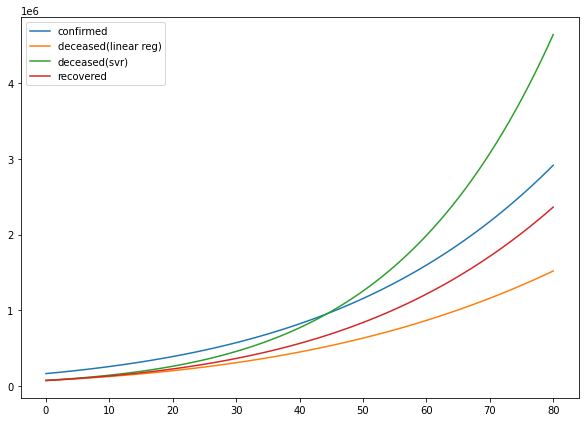

In [0]:
plt.figure(figsize=(10,7))
plt.plot(pipeline1.predict(np.array(list(range(119,200))).reshape(-1,1)), label='confirmed')
plt.plot(pipeline2.predict(np.array(list(range(119,200))).reshape(-1,1)), label='deceased(linear reg)')
plt.plot(svr2.predict(np.array(list(range(119,200))).reshape(-1,1)),label='deceased(svr)')
plt.plot(pipeline3.predict(np.array(list(range(119,200))).reshape(-1,1)), label='recovered')
plt.legend()
plt.show()

For **confirmed** and **recovered** cases, Linear regression model has best score. For **deceased** cases SVR has best score.

But by comparing predicted confirmed cases with predicted deceased cases (predicted by both Linear regression and SVR) for next 80 days, we can see that deceased cases predicted by SVR is higher than number of confirmed cases which is not the trend according to the historical data we have.

Because deceased cases are quite low compared to confirmed cases.

Therefore we are choosing Linear regression for predicting all three cases.

### Input a future date to predict the confirmed, deceased and recovered cases

Enter the future date: (in the format DD MM YYYY): 24 12 2020
Date 2020-12-24 00:00:00
Predicted confirmed cases: 56943766
Predicted deceased cases: 17558235
Predicted recovered cases: 45756241


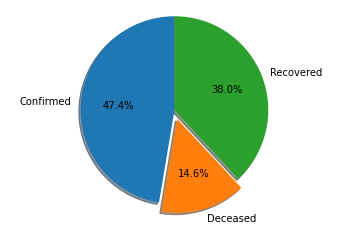

In [0]:
from dateutil import parser
dt=parser.parse(input('Enter the future date: (in the format DD MM YYYY): '))
day_count=(dt-parser.parse('30 jan 2020')).days
print('Date',dt)
c=int(pipeline1.predict(np.array(day_count).reshape(-1,1))[0])
d=int(pipeline2.predict(np.array(day_count).reshape(-1,1))[0])
r=int(pipeline3.predict(np.array(day_count).reshape(-1,1))[0])
print('Predicted confirmed cases:',c)
print('Predicted deceased cases:',d)
print('Predicted recovered cases:',r)

labels = 'Confirmed','Deceased','Recovered'
sizes = [c,d,r]
explode = (0, 0.1, 0)  # only "explode" the 2nd slice

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Regards,

Subham Kumar Sahoo